<a href="https://colab.research.google.com/github/ZhaoQii/IST597/blob/main/IST597_HW3_Custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
#np.random.seed(1178)
#tf.random.set_seed(1178)

In [ ]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn import preprocessing
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train_fs, y_train_fs), (X_test_fs, y_test_fs) = fashion_mnist.load_data()

# first way to normalize data
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

X_train_fs = X_train_fs.astype(float) / 255.
X_test_fs = X_test_fs.astype(float) / 255.

X_train_fs = X_train_fs.reshape([X_train_fs.shape[0], -1])
X_test_fs = X_test_fs.reshape([X_test_fs.shape[0], -1])

# one hot
onehot = preprocessing.OneHotEncoder()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

onehot.fit(y_train)
y_train = onehot.transform(y_train).toarray()
onehot.fit(y_test)
y_test = onehot.transform(y_test).toarray()

y_train_fs = y_train_fs.reshape(-1, 1)
y_test_fs = y_test_fs.reshape(-1, 1)

onehot.fit(y_train_fs)
y_train_fs = onehot.transform(y_train_fs).toarray()
onehot.fit(y_test_fs)
y_test_fs = onehot.transform(y_test_fs).toarray()

# validation set
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

X_train_fs, X_val_fs = X_train_fs[:-10000], X_train_fs[-10000:]
y_train_fs, y_val_fs = y_train_fs[:-10000], y_train_fs[-10000:]

4431872/4422102 [==============================] - 0s 0us/step


## Define Class

In [ ]:
# Define class to build mlp model
class MLP_QZ_Custom(object):
  def __init__(self, size_data, size_input, size_hidden_1, size_hidden_2, size_output, device = None, regularizer = None,
               L1_alpha = 0., L2_alpha = 0.,
               alpha = 1e-2, beta_1 = 0.9, beta_2 = 0.999, beta_3 = 0.999987, e = 1e-8, e_2 = 1e-6):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_data, self.size_input, self.size_hidden_1, self.size_hidden_2, self.size_output, self.device, self.regularizer, \
    self.L1_alpha, self.L2_alpha, self.alpha, self.beta_1, self.beta_2, self.beta_3, self.e, self.e_2 = \
    size_data, size_input, size_hidden_1, size_hidden_2, size_output, device, regularizer, L1_alpha, L2_alpha, alpha, beta_1, beta_2, beta_3, e, e_2
    
    # Xavier initialization
    initializer = tf.initializers.GlorotUniform()

    self.W0 = tf.Variable(initializer(shape = [self.size_data, self.size_input]))
    #self.W0 = tf.Variable(tf.random.normal([self.size_data, self.size_input], stddev = 0.1))
    self.b0 = tf.Variable(tf.zeros([1, self.size_input]))

    self.W1 = tf.Variable(initializer(shape = [self.size_input, self.size_hidden_1]))
    #self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden_1], stddev = 0.1))
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden_1]))

    self.W2 = tf.Variable(initializer(shape = [self.size_hidden_1, self.size_hidden_2]))
    #self.W2 = tf.Variable(tf.random.normal([self.size_hidden_1, self.size_hidden_2], stddev = 0.1))
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))

    self.W3 = tf.Variable(initializer(shape = [self.size_hidden_2, self.size_output]))
    #self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev = 0.1))
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W0, self.W1, self.W2, self.W3, self.b0, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    #return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf, from_logits = False)
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits = True)

    if self.regularizer is None:
      return ce(y_true_tf, y_pred_tf)
    elif self.regularizer == 'L1':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
    elif self.regularizer == 'L2':
      return (ce(y_true_tf, y_pred_tf) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
    elif self.regularizer == 'L1 + L2':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
  
  def backward(self, X_train, y_train, t, m, v, u):
    """
    backward pass
    """

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)

    # update
    m = [self.beta_1 * a + (1 - self.beta_1) * b for a, b in zip(m, grads)]
    v = [self.beta_2 * a + (1 - self.beta_2) * tf.math.square(b) for a, b in zip(v, grads)]
    u = [self.beta_3 * a + (1 - self.beta_3) * tf.math.pow(b, 3) for a, b in zip(u, grads)]
    #print(m[0][0])
    m_hat = [i / (1 - self.beta_1 ** t) for i in m]
    v_hat = [i / (1 - self.beta_2 ** t) for i in v]
    u_hat = [i / (1 - self.beta_3 ** t) for i in u]

    theta = [a - self.alpha * b / (np.sqrt(c)+ self.e * np.cbrt(d) + self.e_2) for a, b, c, d in zip(self.variables, m_hat, v_hat, u_hat)]
    
    # assign values to variables
    for i in range(len(self.variables)):
      self.variables[i].assign(theta[i])
    return(m, v, u)
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)    
    # Compute values in the first hidden layer
    what_0 = tf.matmul(X_tf, self.W0) + self.b0
    hhat_0 = tf.nn.relu(what_0)
    # Compute values in the first hidden layer
    what_1 = tf.matmul(hhat_0, self.W1) + self.b1
    hhat_1 = tf.nn.relu(what_1)
    # Compute values in the second hidden layer
    what_2 = tf.matmul(hhat_1, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    #output = tf.nn.softmax(what_3)
    return output

## Train Model

In [ ]:
size_data, size_input, size_hidden_1, size_hidden_2, size_output = 28 * 28, 512, 256, 128, 10 
batch_size_train = 128
batch_size_val = 16
batch_size_test = 16

In [ ]:
# Set number of epochs
NUM_EPOCHS = 5

# Initialize model
# , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
mlp_on_cpu = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 0.02)
mlp_on_cpu_fs = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 0.02)

# column 0 for MINST column 1 for Fashion MNIST
train_accuracy = np.zeros([NUM_EPOCHS, 2])
val_accuracy = np.zeros([NUM_EPOCHS, 2])
train_loss = np.zeros([NUM_EPOCHS, 2])

time_start = time.time()
for epoch in range(NUM_EPOCHS):

  # for MNIST
  train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_acc_epoch = tf.zeros([1,1], dtype=tf.float32)
  #val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_acc_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)

  t = 0
  m = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
  v = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
  u = [tf.zeros_like(var) for var in mlp_on_cpu.variables]

  for inputs, outputs in train_ds:
    t += 1
    preds = mlp_on_cpu.forward(inputs)
    train_loss_epoch = train_loss_epoch + mlp_on_cpu.loss(preds, outputs)
    m, v, u = mlp_on_cpu.backward(inputs, outputs, t, m, v, u)

  # training acc and loss
  preds = mlp_on_cpu.forward(X_train)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  train_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  train_accuracy[epoch, 0] = train_acc_epoch
  train_loss_epoch = np.sum(train_loss_epoch) / X_train.shape[0]
  train_loss[epoch, 0] = train_loss_epoch
  print('\nMNIST Train Accuracy: {:.4f}'.format(train_acc_epoch))
  print('\nMNIST Number of Epoch = {} - Average Cross Entropy:={}'.format(epoch + 1, train_loss_epoch))

  preds = mlp_on_cpu.forward(X_val)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_val, 1))
  val_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  val_acc_epoch = val_acc_epoch.numpy()
  val_accuracy[epoch, 0] = val_acc_epoch
  print('\nMNIST Validation Accuracy: {:.4f}'.format(val_acc_epoch))

  # for FMNIST
  #train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_acc_epoch = tf.zeros([1,1], dtype=tf.float32)
  #val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_acc_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)

  t = 0
  m = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
  v = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
  u = [tf.zeros_like(var) for var in mlp_on_cpu.variables]

  for inputs, outputs in train_ds:
    t += 1
    preds = mlp_on_cpu_fs.forward(inputs)
    train_loss_epoch = train_loss_epoch + mlp_on_cpu_fs.loss(preds, outputs)
    m, v, u = mlp_on_cpu_fs.backward(inputs, outputs, t, m, v, u)

  # training acc and loss
  preds = mlp_on_cpu_fs.forward(X_train_fs)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train_fs, 1))
  train_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  train_accuracy[epoch, 1] = train_acc_epoch
  train_loss_epoch = np.sum(train_loss_epoch) / X_train.shape[0]
  train_loss[epoch, 1] = train_loss_epoch
  print('\nFashion MNIST Train Accuracy: {:.4f}'.format(train_acc_epoch))
  print('\nFashion MNIST Number of Epoch = {} - Average Cross Entropy:={}'.format(epoch + 1, train_loss_epoch))

  preds = mlp_on_cpu_fs.forward(X_val_fs)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_val_fs, 1))
  val_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  val_acc_epoch = val_acc_epoch.numpy()
  val_accuracy[epoch, 1] = val_acc_epoch
  print('\nFashion MNIST Validation Accuracy: {:.4f}'.format(val_acc_epoch))


time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Text(0.5, 0, 'Epochs')

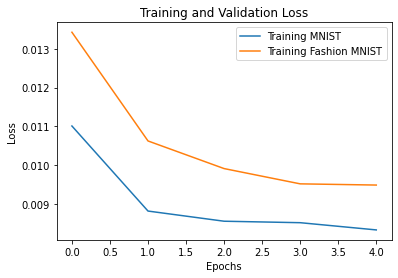

In [26]:
plt.plot(train_loss[:, 0], label = 'Training MNIST')
#plt.plot(val_loss[:, 0], label = 'Validation MNIST')
plt.plot(train_loss[:, 1], label = 'Training Fashion MNIST')
#plt.plot(val_loss[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

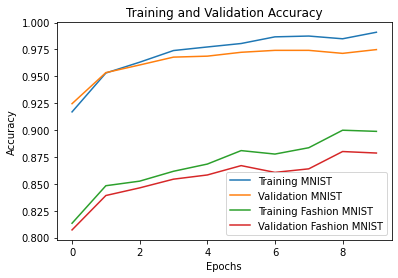

In [ ]:
plt.plot(train_accuracy[:, 0], label = 'Training MNIST')
plt.plot(val_accuracy[:, 0], label = 'Validation MNIST')
plt.plot(train_accuracy[:, 1], label = 'Training Fashion MNIST')
plt.plot(val_accuracy[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

## Bias vs. Variance

In [ ]:
# storage
num_model = 2 # 0 for no regularization 1 for regularization
num_rep = 10
num_dataset = 2  # 0 for MNIST 1 for FMNIST

test_accuracy = np.zeros([num_rep, num_model, num_dataset])
used_time = np.zeros([num_rep, num_model])

In [ ]:
for n in range(num_rep):
  print(n)

  # Set number of epochs
  NUM_EPOCHS = 10

  # Initialize model without regularization
  # , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
  mlp_on_cpu = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output) #, regularizer = 'L2', L2_alpha = 0.1,
  mlp_on_cpu_fs = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output) #, lr = 1e-2, device = 'gpu', optimizer = alg) #, regularizer = 'L2', L2_alpha = 0.1,
  
  time_start = time.time()
  for epoch in range(NUM_EPOCHS):

    t = 0
    m = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    v = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    u = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    # MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    for inputs, outputs in train_ds:
      t += 1
      m, v, u = mlp_on_cpu.backward(inputs, outputs, t, m, v, u)

  for epoch in range(NUM_EPOCHS):

    t = 0
    m = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    v = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    u = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    # FMNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    for inputs, outputs in train_ds_fs:
      t += 1
      m, v, u = mlp_on_cpu_fs.backward(inputs, outputs, t, m, v, u)
  time_taken = time.time() - time_start

  # record time
  used_time[n, 0] = time_taken

  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
  test_accuracy[n, 0, 0] = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  preds_fs = tf.nn.softmax(preds_fs)
  correct_preds_fs = tf.equal(tf.argmax(preds_fs, 1), tf.argmax(y_test_fs, 1))
  test_accuracy[n, 0, 1] = tf.reduce_mean(tf.cast(correct_preds_fs, 'float'))


  # Initialize model with regularization
  # , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
  mlp_on_cpu = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 0.02)
  mlp_on_cpu_fs = MLP_QZ_Custom(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 0.02)
  
  time_start = time.time()
  for epoch in range(NUM_EPOCHS):

    t = 0
    m = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    v = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    u = [tf.zeros_like(var) for var in mlp_on_cpu.variables]
    # MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    for inputs, outputs in train_ds:
      t += 1
      m, v, u = mlp_on_cpu.backward(inputs, outputs, t, m, v, u)

  for epoch in range(NUM_EPOCHS):

    t = 0
    m = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    v = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    u = [tf.zeros_like(var) for var in mlp_on_cpu_fs.variables]
    # FMNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    for inputs, outputs in train_ds_fs:
      t += 1
      m, v, u = mlp_on_cpu_fs.backward(inputs, outputs, t, m, v, u)
  time_taken = time.time() - time_start

  # record time
  used_time[n, 1] = time_taken
    
  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
  test_accuracy[n, 1, 0] = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  preds_fs = tf.nn.softmax(preds_fs)
  correct_preds_fs = tf.equal(tf.argmax(preds_fs, 1), tf.argmax(y_test_fs, 1))
  test_accuracy[n, 1, 1] = tf.reduce_mean(tf.cast(correct_preds_fs, 'float'))

0
1
2
3
4
5
6
7
8
9


In [ ]:
test_accuracy[:, 1, :]

array([[0.86290002, 0.76550001],
       [0.85729998, 0.78200001],
       [0.83499998, 0.74629998],
       [0.87159997, 0.7834    ],
       [0.83530003, 0.73729998],
       [0.82740003, 0.74940002],
       [0.84539998, 0.764     ],
       [0.88849998, 0.77179998],
       [0.83789998, 0.77249998],
       [0.8642    , 0.73250002]])

In [ ]:
used_time[:, 1]

array([667.33868337, 676.989254  , 696.44490123, 654.94622135,
       657.28889894, 665.99384689, 675.46364832, 693.78219604,
       651.33903599, 748.68760395])